# Preparatory Steps 2

Perform low level signal processing including click detection and definition of an amplitude threshold, spectral calculations and principal-component-analysis (PCA).

In [1]:
from IPython.display import Image

In [2]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

## Importing require dependencies and starting a spark context

In [3]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext, DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

In [4]:
%pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat, savemat, whosmat

from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time
import sys
from row_parser import *
from spark_PCA import *
from pyspark.sql import DataFrame

Populating the interactive namespace from numpy and matplotlib


## The Dataset
The full dataset has 5 million clicks, about XXX Gervais and YYY Cuviers, which is about 27GB.

Here we use a sample of about 15MB in size that contains about 2000 samples from each species.

In [5]:
!ls -l ../data/DSE230_version_Data/whale_data_15mb.np

-rw-r--r--  1 jasonkha  staff  15696962 Sep 21 23:43 ../data/DSE230_version_Data/whale_data_15mb.np


In [6]:
file_data = np.load("../data/DSE230_version_Data/whale_data_15mb.np")
file_data_rdd = sc.parallelize(file_data.tolist())

In [7]:
schema = StructType([
     StructField('time', TimestampType(), True),
     StructField('species', StringType(), True),
     StructField('site', StringType(), True),
     StructField('rec_no', StringType(), True),
     StructField('bout_i', LongType(), True),
     StructField('peak2peak', DoubleType(), True),
     StructField('MSN', BinaryType(), True),
     StructField('MSP', BinaryType(), True),
     StructField('TPWS1', LongType(), True),
     StructField('MD1', LongType(), True),
     StructField('FD1', LongType(), True),
     StructField('TPWS2', LongType(), True),
     StructField('MD2', LongType(), True),
     StructField('FD2', LongType(), True),
     StructField('TPWS3', LongType(), True),
     StructField('MD3', LongType(), True),
     StructField('FD3', LongType(), True)
])

### Data schema
The data was originally stored as Matlab files. Those were translated into csv file

#### The feature vector
Each click is defined by the following fields

|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101

In [8]:
df_new = sqlContext.createDataFrame(file_data_rdd, schema).cache()

In [9]:
#count the number of records (clicks) for each species
df_new.groupBy('species').count().collect()

[Row(species='Cuviers', count=2238), Row(species='Gervais', count=1937)]

In [10]:
from scipy import stats
from pyspark.sql.functions import mean as _mean, stddev as _stddev
from IPython.display import display, HTML
mean_peak = _mean(df_new.peak2peak)
std_peak = _stddev(df_new.peak2peak)
df_new_new = df_new.filter((df_new.peak2peak > mean_peak - 3 * std_peak))
print(type(df_new_new), type(df_new))
display(df_new.limit(10).toPandas())

<class 'pyspark.sql.dataframe.DataFrame'> <class 'pyspark.sql.dataframe.DataFrame'>


,time,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
0,2010-08-10 11:45:36.626459,Cuviers,DT,01,5,50.2422,"[249, 15, 233, 183, 175, 163, 34, 64, 191, 125...","[209, 145, 92, 254, 67, 218, 66, 192, 164, 223...",1,0,0,1,0,0,0,0,0
1,2010-08-10 11:46:06.004604,Cuviers,DT,01,5,55.0377,"[241, 99, 204, 93, 75, 200, 1, 192, 155, 230, ...","[18, 20, 63, 198, 220, 93, 65, 192, 0, 0, 0, 0...",1,0,0,1,0,0,0,0,0
2,2010-08-10 12:11:25.866437,Cuviers,DT,01,5,44.9439,"[18, 165, 189, 193, 23, 102, 23, 64, 92, 32, 6...","[242, 176, 80, 107, 154, 207, 67, 192, 177, 22...",1,0,0,1,0,0,0,0,0
3,2010-08-11 09:17:28.543709,Cuviers,DT,01,6,72.7624,"[235, 115, 181, 21, 251, 11, 23, 192, 72, 225,...","[98, 16, 88, 57, 180, 248, 64, 192, 255, 33, 2...",1,0,0,1,0,0,0,0,0
4,2010-08-11 09:18:15.696893,Cuviers,DT,01,6,57.1313,"[63, 53, 94, 186, 73, 76, 26, 192, 9, 138, 31,...","[86, 14, 45, 178, 157, 255, 69, 192, 96, 229, ...",1,0,0,1,0,0,0,0,0
5,2010-08-11 09:21:58.102537,Cuviers,DT,01,6,53.7744,"[29, 90, 100, 59, 223, 79, 28, 64, 112, 206, 1...","[88, 57, 180, 200, 118, 254, 62, 192, 106, 188...",1,0,0,1,0,0,0,0,0
6,2010-08-14 16:31:08.669251,Cuviers,DT,01,11,51.9211,"[5, 52, 17, 54, 60, 189, 246, 191, 172, 28, 90...","[171, 62, 87, 91, 177, 151, 69, 192, 109, 231,...",1,0,0,1,0,0,0,0,0
7,2010-08-16 06:08:09.292679,Cuviers,DT,01,14,49.7682,"[242, 176, 80, 107, 154, 119, 30, 192, 162, 18...","[53, 239, 56, 69, 71, 154, 67, 192, 179, 234, ...",1,0,0,1,0,0,0,0,0
8,2010-09-09 03:46:10.113892,Cuviers,DT,01,79,46.9420,"[142, 117, 113, 27, 13, 96, 10, 64, 143, 228, ...","[102, 102, 102, 102, 102, 138, 80, 192, 104, 3...",1,0,0,1,0,0,0,0,0
9,2010-09-09 14:44:12.201812,Cuviers,DT,01,82,62.6215,"[129, 38, 194, 134, 167, 87, 222, 191, 200, 7,...","[233, 72, 46, 255, 33, 73, 80, 192, 98, 161, 2...",1,0,0,1,0,0,0,0,0


In [11]:
def get_msn(row):
    """ extract MSN from row as numpy array"""
    return unpackArray(row.MSN,data_type=numpy.float64)
def get_msp(row):
    """ extract MSP from row as numpy array"""
    return unpackArray(row.MSP,data_type=numpy.float64)

### Click detection and definition of an amplitude threshold

I will set an amplitude threshold of 100, since almost every click in the 15 MB dataset exceeds this amplitude threshold.

Percentge of Gervais clicks with max amplitude above 100 = 0.9731543624161074
Percentge of Cuviers clicks with max amplitude above 100 = 0.968722073279714


<Figure size 864x720 with 0 Axes>

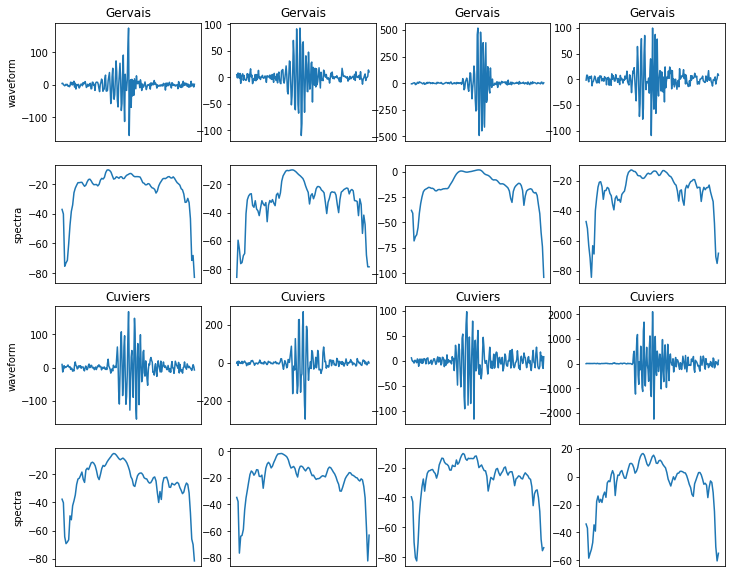

In [12]:
Gervais=df_new.filter(df_new.species=='Gervais')
Cuviers=df_new.filter(df_new.species=='Cuviers')

figure(figsize=(12,10))
i = 0
all_gervais = Gervais.collect()

max_amplitudes_gervais = [np.max(get_msn(row)) for row in all_gervais]

above_100_amplitude_gervais = [1 if amp > 100 else 0 for amp in max_amplitudes_gervais]

print("Percentge of Gervais clicks with max amplitude above 100 =", sum(above_100_amplitude_gervais)/len(max_amplitudes_gervais))


all_cuviers = Cuviers.collect()

max_amplitudes_cuviers = [np.max(get_msn(row)) for row in all_cuviers]

above_100_amplitude_cuviers = [1 if amp > 100 else 0 for amp in max_amplitudes_cuviers]

print("Percentge of Cuviers clicks with max amplitude above 100 =", sum(above_100_amplitude_cuviers)/len(max_amplitudes_cuviers))


# After creating plot ...

#cur_axes = mplot.gca()
#cur_axes.axes.get_xaxis().set_ticks([])

figure(figsize=(12,10))
i=0

for row in Gervais.take(4) + Cuviers.take(4):
    waveform=get_msn(row)
    spectra=get_msp(row)
    subplot(4,4,i+1)
    plot(waveform)
    title(row.species)
    gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        ylabel('waveform')
    subplot(4,4,i+5)
    plot(spectra)
    gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        ylabel('spectra')

    i+=1
    if i==4:
        i=8
   

The `peak2peak` measurement looks like a good feature to predict clicks. Let's run some summary statistics on `peak2peak` for both species.

#### Gervais `peak2peak` summary

In [13]:
Gervais.toPandas()['peak2peak'].describe()

count    1937.000000
mean       55.904884
std         6.628985
min        42.444300
25%        51.830100
50%        54.564500
75%        58.578600
max        96.204600
Name: peak2peak, dtype: float64

#### Cuviers `peak2peak` summary

In [14]:
Cuviers.toPandas()['peak2peak'].describe()

count    2238.000000
mean       57.185070
std         7.898019
min        43.501800
25%        52.005850
50%        55.668350
75%        61.177500
max        95.269800
Name: peak2peak, dtype: float64

The `peak2peak` distribution is nearly identical for the two species, with a mean of about 56 or 57.

## Spectral Calculations
The spectra is computed from the waveform using FFT.

In [15]:
spectra=df_new.rdd.map(get_msp)
COV=computeCov(spectra)

### Mean and covariance of spectra

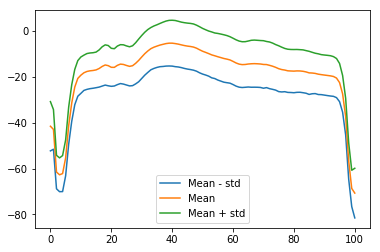

In [16]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plt.plot(M-S)
plt.plot(M)
plt.plot(M+S)
plt.legend(['Mean - std', 'Mean', 'Mean + std'])
plt.show()

#### Raw Spectra

In [17]:
print(spectra.collect()[:2])

[array([-37.7052, -40.2157, -64.4694, -69.3526, -68.2034, -66.6252,
       -49.5534, -52.3493, -42.3063, -38.8516, -34.7091, -27.2549,
       -23.3728, -22.7544, -20.7459, -18.3725, -23.5369, -25.7589,
       -16.9624, -15.6126, -16.6254, -14.2758, -11.84  , -11.3627,
       -12.1285, -13.8271, -17.2974, -21.8288, -23.7577, -20.0803,
       -15.8926, -13.6446, -14.3504, -13.1279, -11.1934,  -9.7308,
        -8.4769,  -7.2438,  -5.8337,  -5.1598,  -5.3962,  -6.3061,
        -7.62  ,  -8.9028,  -9.6228,  -8.9768,  -8.4314,  -9.2537,
       -10.3163, -11.9477, -14.372 , -17.3032, -21.6974, -23.5276,
       -27.9225, -28.6318, -24.6104, -21.0517, -19.6463, -19.0679,
       -19.0846, -20.2084, -22.4005, -23.0807, -23.2711, -25.1411,
       -26.2329, -25.9631, -24.418 , -22.3899, -21.8553, -24.7447,
       -33.0307, -40.0381, -32.2275, -37.9084, -26.3666, -22.4458,
       -22.282 , -21.9781, -24.7282, -29.1269, -29.2755, -26.3737,
       -27.0824, -27.537 , -26.4761, -25.7176, -26.5572, -29.

#### One Dimensional Discrete Fourier Transform

FFT is symmetric so we can simply look at the first half.

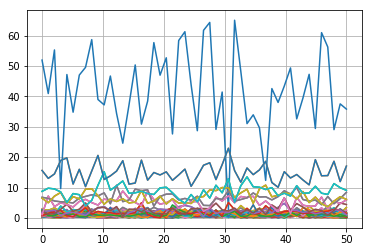

In [18]:
from scipy.fftpack import fft
# Number of sample points
spectra_list = spectra.collect()[:100]
N = len(spectra_list)
# sample spacing
T = 1.0 / N
x = np.linspace(0.0, N*T, N)

yf = fft(spectra_list)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

The amplitude fluctuates between 30 and 60 dB at all frequencies.
At 30 Hz frequency, amplitude drops close to 0 dB.

### PCA of spectra



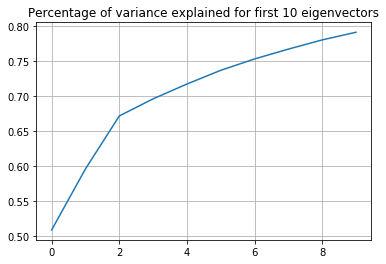

In [19]:
## Get Spectra
spectra=df_new.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction for first 10 eigenvectors
plot(cumsum(eigval[:10]))
grid()
title("Percentage of variance explained for first 10 eigenvectors");

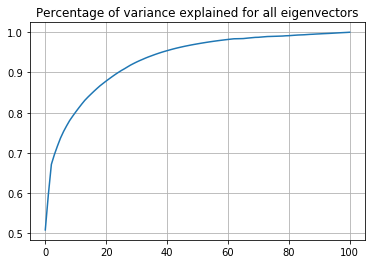

In [20]:
## Check the Reconstruction using all eigenvectors
plot(cumsum(eigval))
grid()
title("Percentage of variance explained for all eigenvectors");

### Visualizing the first 4 eigen vectors

**Question to John:** `ev0` seems to relate to the overall magnitude of the spectra.  Can you interpret `ev1,ev2,ev3`?

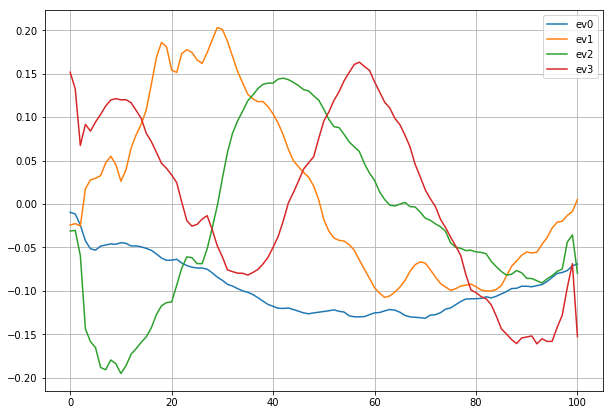

In [21]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

`ev1` could be related to the amplitude of the spectra, since both peak around 30.

`ev2` could be related to whether spectra favors a direction of negative amplitude initially. A higher value is more likely to belong to a Cuvier.

`ev3` could be related to whether spectra favors a direction of positive amplitude initially, but it becomes quite similar to `ev2` after the first 50 values.

**Something to do**: verify that all of the eigen-vectors have length 1.

In [22]:
## Using First 10 Eigen Vectors
V=eigvec[:,0:10]
## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

In [23]:
print("Sum of all eigenvalues:", sum(eigval))

Sum of all eigenvalues: 0.9999999999999997


## Creating Training Data

Returns the projection, rmse , peak2peak and the label 

In [24]:
def calc_stats(row):
    array = trimmed_spectra(row)
    projections = project(array)
    rmse = np.std(array)
    peak2peak = row.peak2peak
    label = 0 if row.species==u'Gervais' else 1
    return np.hstack((projections, [rmse, peak2peak, label]))

In [25]:
df_trimmed_data = df_new.rdd.map(calc_stats)

In [26]:
data = df_trimmed_data.collect()

### Writing Data

In [27]:
np_data = np.array(data)
np.save(open('../data/DSE230_version_Data/processed_data_15mb.np', 'wb'), np_data)

## Projecting on top eigenvectors
We observe that eigvec1 represents mostly the loudness of the click, and has little information about the species.

We therefor project on eigen-vectors 2 and 3.

In [28]:
V=eigvec[:,1:3] #vectors on which to project, chose 1,2 eigen vectors
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

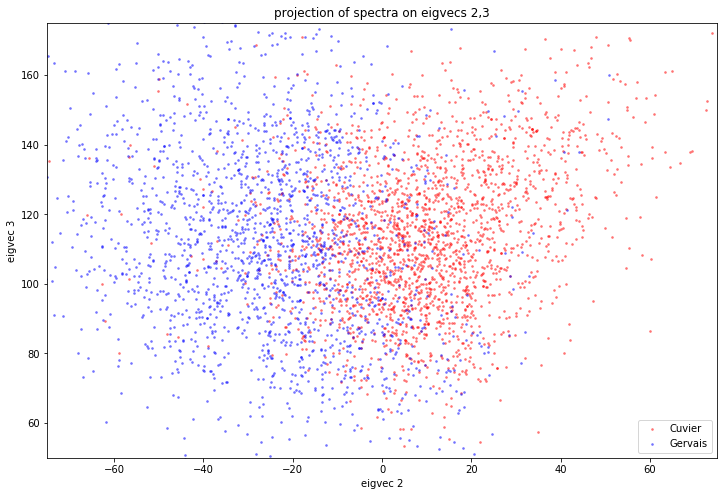

In [29]:
Cuvier_projections=np.array(Cuviers.rdd.map(project).collect())
Gervais_projections=np.array(Gervais.rdd.map(project).collect())

figure(figsize=[12,8])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', s=3, alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', s=3, alpha=0.4)
title('projection of spectra on eigvecs 2,3')
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-75,75])
xlabel('eigvec 2')
ylim([50,175])
ylabel('eigvec 3');

Observe that there are regions where the conditional probability is close to 0 or 1

There is also an overlap region where there two species are mixed.

### Highlighting overlap area

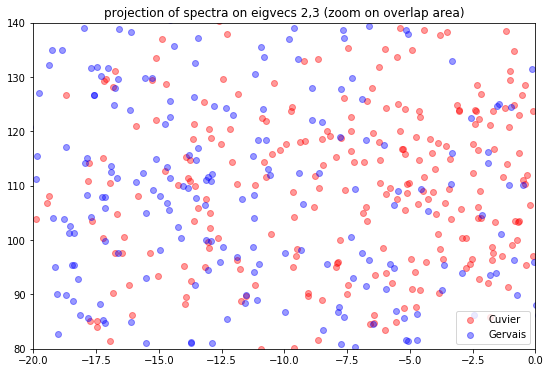

In [30]:
Cuvier_projections=np.array(Cuviers.sample(False,0.5).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.5).rdd.map(project).take(10000))

figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
title('projection of spectra on eigvecs 2,3 (zoom on overlap area)')
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-20, 0])
ylim([80, 140]);